In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## 1. Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [3]:
# Save the input and target variables
print(diabetes_dataset.keys())
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()
print(len(targets))
print(targets[:10])

442
[-0.01471948 -1.00165882 -0.14457991  0.69951294 -0.22249618 -0.71596585
 -0.18353805 -1.15749134 -0.54714728  2.05006151]


In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1], )),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)        
    ])
    
    return model

model = get_model()

In [7]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, validation_split=0.15, epochs=100, batch_size=64, verbose=False)

In [10]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 1.1158 - mae: 0.7251


[0.8257516357633803, 0.725137]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

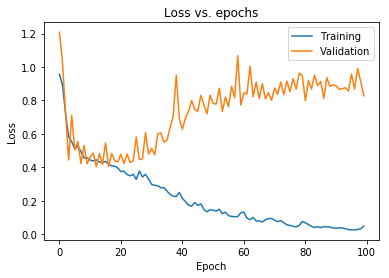

In [12]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## 2. Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate): # wd: weight decay
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [18]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5807 - mae: 0.5116


[0.4191137115160624, 0.5115909]

#### Plot the learning curves

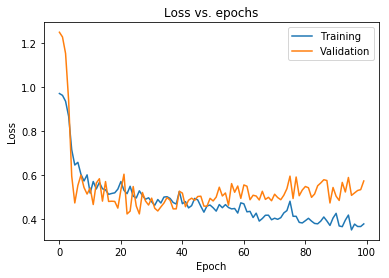

In [19]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## 3. Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom Training Callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished training!")

In [21]:
# Write a custom Testing Callback
class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing....")

    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")

    def on_test_end(self, logs=None):
        print("Finished testing!")

In [22]:
# Write a custom Prediction Callback
class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction....")

    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")

    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [23]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [25]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [26]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


0.8324550761116876

In [27]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction....
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction!


array([[-0.06970388],
       [-0.03405069],
       [-0.02699477],
       [ 0.06572079],
       [ 0.16016836],
       [ 0.07501188],
       [-0.0660079 ],
       [ 0.00151314],
       [ 0.17008008],
       [ 0.11476584],
       [ 0.1284834 ],
       [ 0.06392751],
       [-0.02083692],
       [ 0.1834889 ],
       [-0.07572434],
       [-0.06810559],
       [-0.04418669],
       [-0.07570568],
       [ 0.21231966],
       [ 0.09715419],
       [-0.08417977],
       [-0.02199045],
       [-0.08146049],
       [ 0.12679534],
       [-0.080349  ],
       [ 0.18938273],
       [ 0.11036247],
       [ 0.13809451],
       [ 0.06412277],
       [ 0.01294365],
       [ 0.10968532],
       [-0.03396866],
       [ 0.09938905],
       [ 0.00221402],
       [ 0.20180716],
       [ 0.13046522],
       [-0.08225251],
       [ 0.15197738],
       [-0.02184357],
       [ 0.11420789],
       [ 0.22447959],
       [ 0.14162897],
       [ 0.22096318],
       [ 0.16667967],
       [-0.08257639]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## 4. Early stopping / patience

#### Re-train the models with early stopping

In [28]:
# Re-train the unregularised model
unregularized_model = get_model()
unregularized_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularized_model.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [29]:
# Evaluate the model on the test set
unregularized_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5968


0.5070624748865763

In [30]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                    validation_split=0.15, batch_size=64, verbose=False,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [31]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5821


0.5357730587323507

#### Plot the learning curves

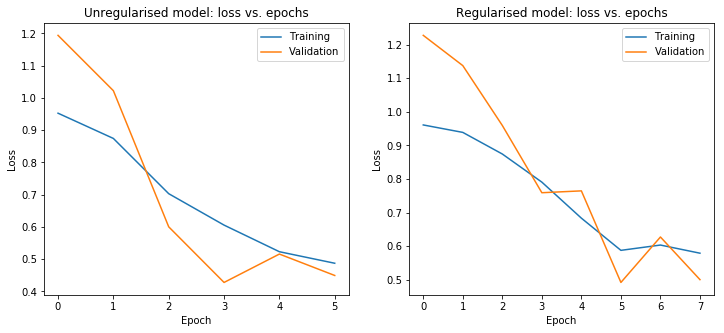

In [32]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show();